# Model development

This notebook is intended for the exploration and development of price forecasting models.

Raw data sources:
- [Elexon BMRS API](https://bmrs.elexon.co.uk/api-documentation/introduction)
- Met Office (2025): MIDAS Open: UK hourly weather observation data, v202507. NERC EDS Centre for Environmental Data Analysis, 18 July 2025. doi:10.5285/99173f6a802147aeba430d96d2bb3099.
- Met Office (2025): MIDAS Open: UK hourly solar radiation data, v202507. NERC EDS Centre for Environmental Data Analysis, 18 July 2025. doi:10.5285/76e54f87291c4cd98c793e37524dc98e.

Users can run the `process_raw_data.py` script to create the datasets used in this notebook.

In [ ]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('seaborn-v0_8-colorblind')

In [9]:
# Load datasets
df_electricity = pd.read_csv("electricity_data.csv")
df_weather = pd.read_csv("weather_data.csv")

print(f"Electricity data memory usage: {np.sum(df_electricity.memory_usage()) / 10**6} MB")
print(f"Weather data memory usage: {np.sum(df_weather.memory_usage()) / 10**6} MB")

print("\nElectricity data columns:\n", df_electricity.columns)
print("\nWeather data columns:\n", df_weather.columns)

Electricity data memory usage: 8.548612 MB
Weather data memory usage: 5.886628 MB

Electricity data columns:
 Index(['settlementDate', 'settlementPeriod', 'startTime', 'BIOMASS', 'GAS',
       'COAL', 'OIL', 'NUCLEAR', 'SOLAR', 'WIND', 'OTHER', 'INTER', 'INDO',
       'ITSO', 'price', 'volume'],
      dtype='object')

Weather data columns:
 Index(['ob_time', 'wind_speed', 'wind_direction', 'visibility',
       'air_temperature', 'glbl_irad_amt', 'location'],
      dtype='object')


Make sure dataset timestamps are pandas.Timestamp objects:

In [10]:
df_electricity['startTime'] = pd.to_datetime(df_electricity['startTime'])
df_weather['ob_time'] = pd.to_datetime(df_weather['ob_time'])

In [11]:
df_electricity.head()

,settlementDate,settlementPeriod,startTime,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,INTER,INDO,ITSO,price,volume
0,2021-01-01,1,2021-01-01 00:00:00+00:00,3116.0,11268.0,0.0,0.0,5949.0,0.0,4734.688,576.0,3428.0,28263.0,28880.0,68.54,407.30
1,2021-01-01,2,2021-01-01 00:30:00+00:00,3118.0,11526.0,0.0,0.0,5956.0,1.0,4524.192,569.0,3572.0,28403.0,29018.0,69.82,601.40
2,2021-01-01,3,2021-01-01 01:00:00+00:00,3087.0,11240.0,0.0,0.0,5948.0,1.0,4423.037,535.0,3570.0,27633.0,28252.0,67.42,608.00
3,2021-01-01,4,2021-01-01 01:30:00+00:00,3117.0,10365.0,0.0,0.0,5950.0,0.0,4309.821,521.0,3568.0,26768.0,27625.0,65.45,579.35
4,2021-01-01,5,2021-01-01 02:00:00+00:00,3113.0,10020.0,0.0,0.0,5949.0,0.0,4306.346,517.0,3512.0,25876.0,27051.0,59.44,729.40


In [12]:
df_weather.head()

,ob_time,wind_speed,wind_direction,visibility,air_temperature,glbl_irad_amt,location
0,2021-01-01 00:00:00,1.028,360.0,500.0,0.5,0.0,Heathrow
1,2021-01-01 01:00:00,1.028,340.0,350.0,0.2,0.0,Heathrow
2,2021-01-01 02:00:00,1.028,320.0,400.0,0.2,0.0,Heathrow
3,2021-01-01 03:00:00,2.056,280.0,320.0,0.0,0.0,Heathrow
4,2021-01-01 04:00:00,2.056,290.0,250.0,-0.2,0.0,Heathrow


Plot electricity generation breakdown:

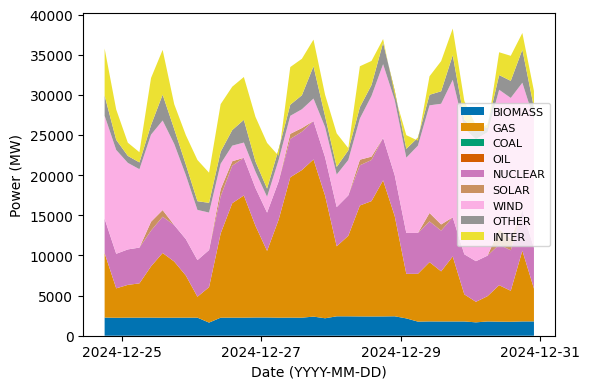

In [13]:
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter

generation_types = ['BIOMASS', 'GAS','COAL', 'OIL', 'NUCLEAR', 'SOLAR', 'WIND', 'OTHER', 'INTER']

colors = sns.color_palette("colorblind", len(generation_types))
fig, ax = plt.subplots(figsize=(6, 4), layout='tight')

# note that data is downsampled
ax.stackplot(df_electricity['startTime'][-300::8], [df_electricity[gt][-300::8] for gt in generation_types], labels=generation_types, colors=colors)

ax.legend(fontsize=8)
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))  # Max ~10 ticks
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))  # e.g., 2022-01-15
ax.set_xlabel('Date (YYYY-MM-DD)', fontsize=10)
ax.set_ylabel('Power (MW)', fontsize=10)
plt.show()